In [173]:
import numpy as np
import pandas as pd

import calendar

from matplotlib import pyplot as pp
%matplotlib inline  

import seaborn as sb
sb.set(font_scale = 1.5, rc={'text.usetex' : False}, context = 'notebook')

from sklearn.model_selection import (train_test_split,
                                     cross_val_score,
                                     GridSearchCV)

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import (GradientBoostingRegressor,
                              ExtraTreesRegressor,
                              BaggingRegressor)

from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.externals import joblib

**A quick first look at the data set**

In [174]:
master = pd.read_csv('forestfires.csv')
workds = master.copy()

In [175]:
# take a quick peek at the data set
workds.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0



   1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
   
   2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
   
   3. month - month of the year: "jan" to "dec" 
   
   4. day - day of the week: "mon" to "sun"
   
   5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
   
   6. DMC - DMC index from the FWI system: 1.1 to 291.3 
   
   7. DC - DC index from the FWI system: 7.9 to 860.6 
   
   8. ISI - ISI index from the FWI system: 0.0 to 56.10
   
   9. temp - temperature in Celsius degrees: 2.2 to 33.30
   
   10. RH - relative humidity in %: 15.0 to 100
   
   11. wind - wind speed in km/h: 0.40 to 9.40 
   
   12. rain - outside rain in mm/m2 : 0.0 to 6.4 
   
   13. area - the burned area of the forest (in ha): 0.00 to 1090.84 
   
(this output variable is very skewed towards 0.0, thus it may make sense to model with the logarithm transform).

The descriptions given for FFMC, DMC, DC and ISI are not very informative, a quick google search finds the following URL: http://cwfis.cfs.nrcan.gc.ca/background/summary/fwi giving the following information:

**Fine Fuel Moisture Code**
The Fine Fuel Moisture Code (FFMC) is a numeric rating of the moisture content of litter and other cured fine fuels. This code is an indicator of the relative ease of ignition and the flammability of fine fuel.

**Duff Moisture Code**
The Duff Moisture Code (DMC) is a numeric rating of the average moisture content of loosely compacted organic layers of moderate depth. This code gives an indication of fuel consumption in moderate duff layers and medium-size woody material.

**Drought Code**
The Drought Code (DC) is a numeric rating of the average moisture content of deep, compact organic layers. This code is a useful indicator of seasonal drought effects on forest fuels and the amount of smoldering in deep duff layers and large logs.

**Initial Spread Index**
The Initial Spread Index (ISI) is a numeric rating of the expected rate of fire spread. It combines the effects of wind and the FFMC on rate of spread without the influence of variable quantities of fuel.

Are there any missing values in this data set?

In [176]:
# are there any missing values
'Yes' if np.count_nonzero( workds.isnull() ) else 'No'

'No'

** Initial Thought**

Predicting fire burn area should help in directing resources over large areas. A highly interpretable model might provide information on fire prevention. One might therefore be inclined to look at e.g. multi-linear regression or generalized additive models.

**Train test split**

Split the data into training and testing sets before any visualization is done. The final model must generalize well. We don't want visualizations of the test data to influence how we attack the problem.

In [177]:
# Before going any further do a train test split and work only on the training set going forward
trn, tst = train_test_split(workds, test_size = 0.25, random_state = 333)

**Visulaize the dataset**

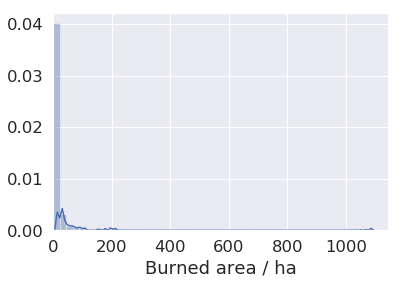

In [178]:
# plot the distribution of the response variable
_ = sb.distplot(trn['area'], bins=None,  axlabel='Burned area / ha')
_ = pp.xlim(0, trn['area'].max() * 1.05)

The response variable, burned area, is highly skewed towards small fires. It might be useful to transform this with e.g. a Log10() scaling. We'll see how well we can do with the unscaled response first.  

In [179]:
# median shows how scewed this response variable is 
print('median burned area: {:.2f}'.format(trn['area'].median()))
print('standard deviation of burned area: {:.2f}'.format(trn['area'].std()))

median burned area: 0.43
standard deviation of burned area: 60.94


In [180]:
# visualize spatial statistics

# group the data by the spatial X and Y axes
group = trn.groupby(['X', 'Y'], as_index = False)

# calculate grouped data statistics
xy_sum = group[['area']].sum()
xy_sum = xy_sum.pivot('X', 'Y', 'area')

xy_cnt = group[['area']].count()
xy_cnt = xy_cnt.pivot('X', 'Y', 'area')

xy_med = group[['area']].median()
xy_med = xy_med.pivot('X', 'Y', 'area')

xy_std = group[['area']].var()
xy_std = xy_std.pivot('X', 'Y', 'area')

xy_std = np.sqrt(xy_std)

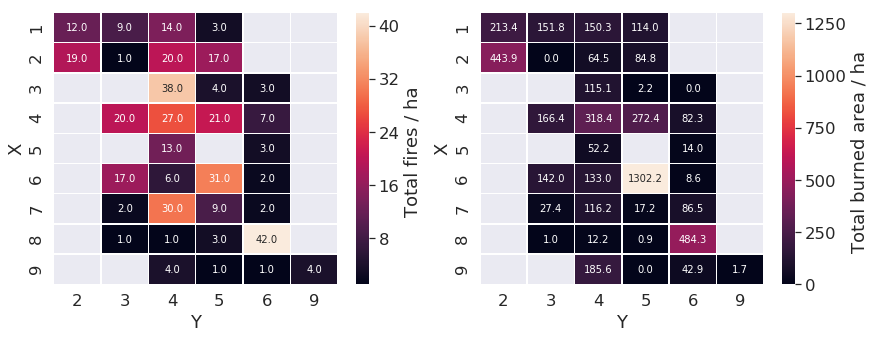

In [181]:
fig, axes = pp.subplots(nrows = 1, ncols = 2, figsize = (14,5))

# make heat maps over the X-Y grid
_ = sb.heatmap(xy_cnt, annot=True, fmt=".1f", linewidths=.5, ax = axes[0],
               annot_kws = {'fontsize': 10}, cbar_kws = {'label': 'Total fires / ha '})

_ = sb.heatmap(xy_sum, annot=True, fmt=".1f", linewidths=.5, ax = axes[1],
               annot_kws = {'fontsize': 10}, cbar_kws = {'label': 'Total burned area / ha '})

- Most fires occur at central and low X-Y coordinates, with the exception of one very high fire count grid reference at (8, 6).


- Comparing total fires with total burned area there is some evidence that fires at low X are small and numerous, where fires at high X are less frequent but larger.

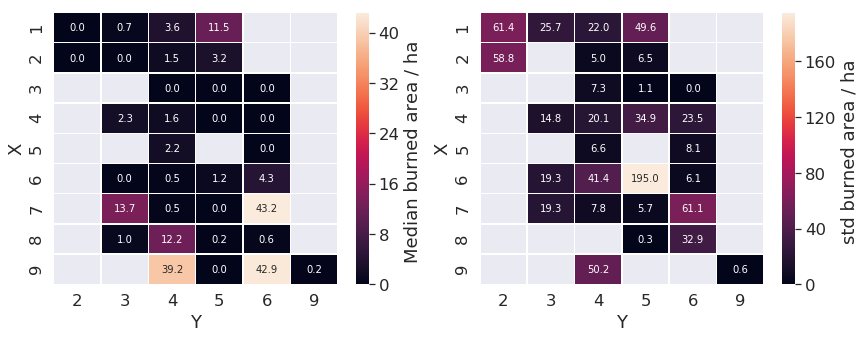

In [182]:
fig, axes = pp.subplots(nrows = 1, ncols = 2, figsize = (14,5))

_ = sb.heatmap(xy_med, annot=True, fmt=".1f", linewidths=.5, ax = axes[0],
                              annot_kws = {'fontsize': 10}, cbar_kws = {'label': 'Median burned area / ha '})

_ = sb.heatmap(xy_std, annot=True, fmt=".1f", linewidths=.5, ax = axes[1],
               annot_kws = {'fontsize': 10}, cbar_kws = {'label': 'std burned area / ha '})

- The median burned area reinforces the last bullet, that is to say, smaller fires dominate low-X regions wheres larger fires dominate at high-X regions.

In [183]:
# a look at the categorical variables

months = [month.lower() for month in list( calendar.month_abbr[1:] )]
days = [day.lower() for day in list( calendar.day_abbr )]

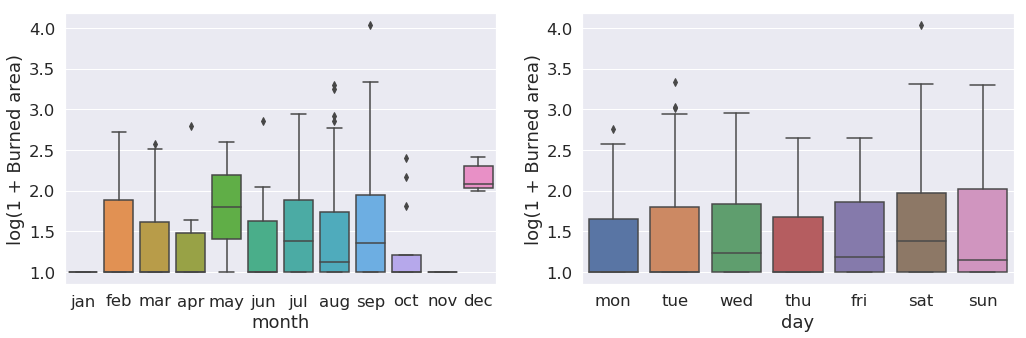

In [184]:
fig, (ax1, ax2) = pp.subplots(ncols = 2, nrows = 1, figsize = (17, 5))

_ = sb.boxplot(x = trn["month"], y = np.log10(1 + trn["area"]) + 1, ax = ax1, order = months)
_ = sb.boxplot(x = trn["day"], y = np.log10(1 + trn["area"]) + 1, ax = ax2, order = days)
_ = ax1.set_ylabel('log(1 + Burned area)')
_ = ax2.set_ylabel('log(1 + Burned area)')

- The average burned area is largest in Dec. However this may be the result of a single or a few fires since the width of the distribution is small. The largest fires tend to occur in the summer months, Aug through Sep.


- There is no obvious trend in area burned on a given day of the week.

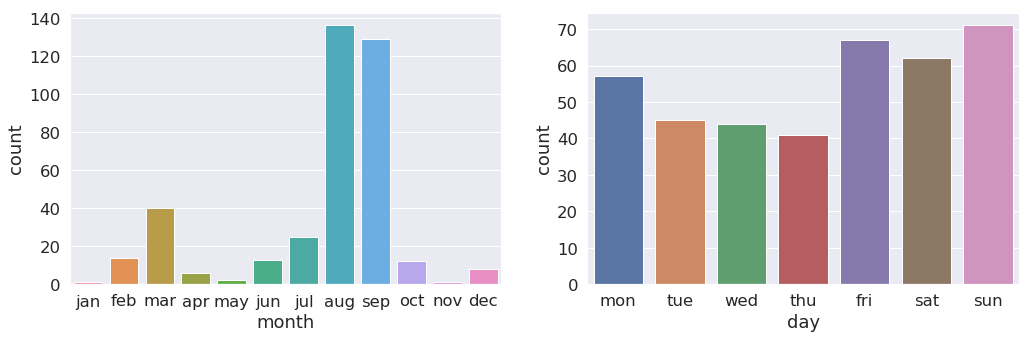

In [185]:
# What does the fire count as a function of month and day look like?

fig, (ax1, ax2) = pp.subplots(ncols = 2, nrows = 1, figsize = (17, 5))
sb.countplot(trn['month'], order = months, ax = ax1)
sb.countplot(trn['day'], order = days, ax = ax2)

- Most fires occur in the summer months Aug through Sep.


- Most fires occur on the weekend, perhaps pointing to human activity.

In [186]:
# correlation matrix

corr = trn.corr()
corr.style.background_gradient()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
X,1,0.53907,-0.05753,-0.0422055,-0.0673796,-0.0462786,-0.0354943,0.0906823,0.0164973,0.0826333,0.021309
Y,0.53907,1,-0.0549673,0.0184105,-0.0777091,0.000954466,-0.00903657,0.0678051,-0.0172961,0.0282469,-0.000603339
FFMC,-0.05753,-0.0549673,1,0.396263,0.349075,0.554901,0.427017,-0.258499,-0.00574354,0.0572894,0.0325523
DMC,-0.0422055,0.0184105,0.396263,1,0.672081,0.368163,0.461786,0.11077,-0.0998979,0.109255,0.0388297
DC,-0.0673796,-0.0777091,0.349075,0.672081,1,0.283389,0.469741,0.0100873,-0.204373,0.064202,0.0437702
ISI,-0.0462786,0.000954466,0.554901,0.368163,0.283389,1,0.423489,-0.119789,0.105196,0.0888935,-0.0148726
temp,-0.0354943,-0.00903657,0.427017,0.461786,0.469741,0.423489,1,-0.49414,-0.226172,0.0421352,0.0745067
RH,0.0906823,0.0678051,-0.258499,0.11077,0.0100873,-0.119789,-0.49414,1,0.00734151,0.180186,-0.0817052
wind,0.0164973,-0.0172961,-0.00574354,-0.0998979,-0.204373,0.105196,-0.226172,0.00734151,1,0.147836,-0.0155672
rain,0.0826333,0.0282469,0.0572894,0.109255,0.064202,0.0888935,0.0421352,0.180186,0.147836,1,-0.0215796


The FWI indicators are all correlated with one another and with temperature. There may be some (multi-)collinearity, which will increase the variance of a fitted model. It might be useful to combine these in to a single predictor. We'll stick with the full set of predictors for now.

There is no significant correlation between any one of the predictors and the response. A multi-linear regression or generalized additive model is probably not going to eke out a signal. Highly non-linear methods might be better suited at the expense of interpretation. 

**Data preparation**

In [187]:
# it's a good idea to scale the quantitative features
scaler = StandardScaler()

trn_quant = trn.drop(['month', 'day', 'area'], axis = 1)
trn_scaled = scaler.fit_transform(trn_quant)

In [188]:
# repackage the scaled dataset
trn_scl = pd.DataFrame(data = trn_scaled, columns = trn_quant.columns, index = trn_quant.index)

In [189]:
# merge the categorical variables and response back in
trn_scl = trn_scl.join(trn[['month', 'day', 'area']])

In [190]:
# encode the categorical variables
trn_scl = pd.get_dummies(trn_scl, columns = ['month','day'])

In [191]:
# last thing is to transform the area
#scaled['area'] = np.log10( scaled['area'] + 1. )
#trn_scl.head()

**Try some tree based ensamble learning methods**

In [192]:
# gradient boosting
gbr = GradientBoostingRegressor(random_state = 7)

In [193]:
# find the score using cross validation
gbr_scrs = cross_val_score(gbr, trn_scl.drop(['area'], axis = 1), trn_scl['area'],
                           scoring = 'neg_mean_absolute_error', cv = 5)

In [194]:
# see scores
mse = -gbr_scrs.mean( axis = -1 )
print ('Cross validated mean absolute error from gradient boosting: {:.2f}'.format(mse))

Cross validated mean absolute error from gradient boosting: 20.63


In [195]:
# Extremely Randomized Trees
etr = ExtraTreesRegressor(random_state = 23)

In [196]:
# find the score using cross validation
etr_scrs = cross_val_score(etr, trn_scl.drop(['area'], axis = 1), trn_scl['area'],
                           scoring = 'neg_mean_absolute_error', cv = 5)

In [197]:
mse = -etr_scrs.mean( axis = -1 )
print ('Cross validated mean absolute error from extremely randomized trees: {:.2f}'.format(mse))

Cross validated mean absolute error from extremely randomized trees: 21.51


In [198]:
# Bagging
bag = BaggingRegressor(random_state = 323)

In [199]:
bag_scrs = cross_val_score(bag, trn_scl.drop(['area'], axis = 1), trn_scl['area'],
                          scoring = 'neg_mean_absolute_error', cv = 5)

In [200]:
mse = -bag_scrs.mean( axis = -1 )
print ('Cross validated mean absolute error from bagging: {:.2f}'.format(mse))

Cross validated mean absolute error from bagging: 23.26



    Using default hyperparameters is not the most robust way to compare models 
    in this way but we'll assume that the default hyperparameters are set to
    give reasonable starting points for most problems.
    
    All the models give similar results and are pretty poor, gradient boosting 
    gives the lowest cross validation error so we'll take this forward
    and try to tune the parameters. 
    

**Tune the model**

Let's try a cross validated grid search over learning rate and tree depth

In [201]:
# lets try a grid search for the boosting model
gbr = GradientBoostingRegressor(n_estimators = 1000)
params = {'learning_rate': [0.1, 0.01, 0.001, 0.0001], 'max_depth':[1, 2, 4, 6, 8]}
gbrcv = GridSearchCV(gbr, params, cv=5, scoring='neg_mean_absolute_error')

In [202]:
_ = gbrcv.fit(trn_scl.drop(['area'], axis = 1), trn_scl['area'])

In [203]:
mse = -gbrcv.best_score_
print ('Cross validated mean absolute error from tuned gradient boosting: {:.2f}'.format(mse))

Cross validated mean absolute error from tuned gradient boosting: 17.45


The tuning makes a small improvement but overall the error is still pretty large. We of course expect the test error to be larger still, let's see

**Prep the test data**

In [204]:
# prep that data as we did for the training set
scaler = StandardScaler()

# since training and test set were randomly selected we expect similar scalings
tst_quant = tst.drop(['month', 'day', 'area'], axis = 1)
tst_scaled = scaler.fit_transform(tst_quant)

In [205]:
# repackage the scaled dataset
tst_scl = pd.DataFrame(data = tst_scaled, columns = tst_quant.columns, index = tst_quant.index)

In [206]:
# merge the categorical variables and predictor back in
tst_scl = tst_scl.join(tst[['month', 'day', 'area']])

In [207]:
# encode the categorical variables
tst_scl = pd.get_dummies(tst_scl, columns = ['month','day'])

In [208]:
# finally ensure test set categorical columns mirror the training set
nrows = tst_scl.shape[0]

for col in trn_scl.columns:
    if col in tst_scl.columns:
        continue
    
    tst_scl[col] = np.zeros( nrows, dtype = int )

**Apply the tuned model to the test data**

In [209]:
tst_pred = gbrcv.predict( tst_scl.drop(['area'], axis = 1) )
mean_absolute_error(tst_scl['area'], tst_pred)

21.87874692117938

Text(0,0.5,'Predicted burned area / ha')

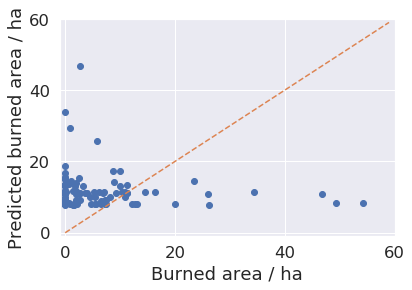

In [210]:
# plot test predictions against true burned area

pp.plot(tst_scl['area'], tst_pred, 'o')
pp.plot(np.arange(0,60),np.arange(0,60), '--')
pp.xlim(-1, 60)
pp.ylim(-1, 60)
pp.xlabel('Burned area / ha')
pp.ylabel('Predicted burned area / ha')

This is very disappointing, the model predicts an almost constant response. There also seems to be a lower limit on the predicted burned area. Does this reflect a lower limit in the training data? It would be prudent to investigate this further.

Text(0,0.5,'Deviance')

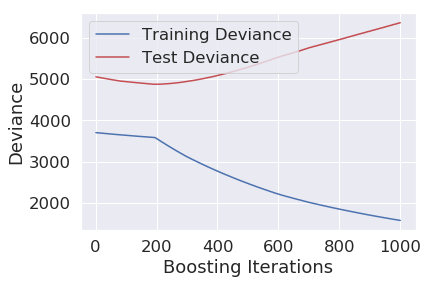

In [211]:
# we can now plot training and test set deviance

gbr_tuned = gbrcv.best_estimator_
test_score = np.zeros((1000,), dtype=np.float64)

for i, pred_cv in enumerate(gbr_tuned.staged_predict( tst_scl.drop(['area'], axis = 1) )):
    test_score[i] = gbr_tuned.loss_(tst_scl['area'], pred_cv)
    

pp.plot(np.arange(1000) + 1, gbr_tuned.train_score_, 'b-',
         label='Training Deviance')
pp.plot(np.arange(1000) + 1, test_score, 'r-',
         label='Test Deviance')
pp.legend(loc = 'upper left')
pp.xlabel('Boosting Iterations')
pp.ylabel('Deviance')

The test set deviance increases beyond ~200 iterations, a clear sign that the model is overfit. It would have been useful to do this testing on a separate validation dataset instead of the test set. This would have allowed us to go back and address the overfitting. Unfortunately this is a very difficult dataset to work with in that it is small with few if any predictors well correlated with the response. We would likely not get any reward for further decreasing the size of the training set.

Text(0,0.5,'Relative Importance')

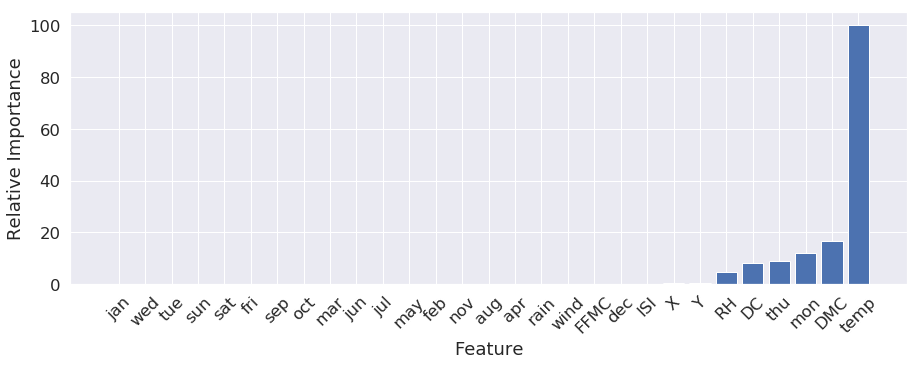

In [212]:
# Plot feature importance

fig  = pp.figure(figsize = (15,5))

feature_importance = gbr_tuned.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
pp.bar(pos, feature_importance[sorted_idx], align='center')
features  = np.array( tst_scl.drop('area', axis = 1).columns)
features = np.array([f.replace('month_','').replace('day_','') for f in features])
_ = pp.xticks(pos, features[sorted_idx], rotation = 45)

pp.xlabel('Feature')
pp.ylabel('Relative Importance')

Many of the features have little or no importance in final model, they are probably adding noise, indicating that some feature selection might be prudent.

Temperature has the highest importance of all the features, which makes a lot of sense. However, both wind and rain have no importance. One might have expected fires to burn less area at times of high precipitation and for high winds to fan the flames.

**REC Curve**

The forest fires dataset was presented in Cortez & Morais 2007, where the authors present a solution to this problem using a trained support vector machine. In assessing the accuracy of their model they produce an REC curve, which plots the error tolerance (x-axis), given in terms of the absolute deviation, versus the percentage of points predicted within the tolerance (y-axis). The ideal regressor should present a REC area close to 1.0.

The REC curve for the model presented in this notebook is plotted below alongside the REC curve for Cortez & Morais' SVM (which was digitally scanned using the tool at https://automeris.io/WebPlotDigitizer/). 

Text(0,0.5,'Tollerence')

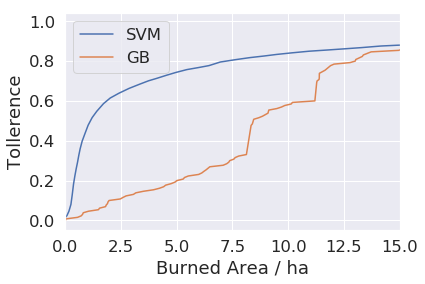

In [213]:
# REC curve
eabs_cv = np.abs( tst_scl['area'] - tst_pred )
esorted_cv = np.sort(eabs_cv)
cev_cv = np.array([ np.sum( (esorted_cv < x).astype(float) )/esorted_cv.size for x in esorted_cv])

#cevrf = pd.read_csv('cev-rf.csv')
cevsv = pd.read_csv('cev-svm.csv')

#pp.plot(cevrf['area'], cevrf['cev']/100., label = 'RF')
pp.plot(cevsv['area'], cevsv['cev']/100., label = 'SVM')
pp.plot(esorted_cv, cev_cv, label = 'GB')

pp.legend()
pp.xlim(0, 15)
pp.xlabel('Burned Area / ha')
pp.ylabel('Tollerence')

**Conclusion**

This is not a simple problem. There is little correlation amongst the predictor variables and the response variable. It would be prudent to try and understand this lack of correlation better.

Fire fighting and prevention activity may be one reason for the observed lack of correlation. The fact that this dataset exists indicates that there is already some effort going into fire prevention. One could imagine a scenario in which many fires have the capacity to become very large but are extinguised before they have the chance to do so. If information pertaining to fire prevention is availibale it would likely be an extremely valuable addition to this dataset.

It was shown that the gradient boosting model was likely overfitting. Controlling the depth of trees and learning rate are two methods which were used to prevent overfitting. Scikit-learn provides several more, including the ability to enforce a lower bound on the number of samples in a leaf. This limits the ability of the boosting algorithm to form leaves that capture single outlying data points, thus reducing variance and overfitting. 

As with random forests, introducing randomization into the boosting algorithm can also reduce varaince. Scikit-learn provides two methods. First by growing each tree with a random subsample of the training set and second by randomly sub sampling the features considered for each node. In summary, much more tuning of the model is possible.

Gradient boosting, performs feature selection naturally. However with use of a validation set it would have been possible to use the feature importance plot presented above to do some manual feature selection. In particular most of the days and months have no relevance to the problem and are probably just adding noise. Unfortunately, the use of a validation set for this purpose would necessarily reduce the training data, further contributing to the difficulty of trying to eke out a weak signal from a small dataset. 

In [214]:
# finally pickle the model for later
joblib.dump([scaler, gbr_tuned], 'gbr_model.pkl')